**Projet 10**: mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
working_directory= '/content/gdrive/MyDrive/Colab Notebooks/OC_projet10'

In [3]:
import pandas as pd
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats as st
from scipy.stats import t, shapiro, norm

from sklearn.model_selection import train_test_split,validation_curve,learning_curve,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# **Analyse descriptive des données**

In [4]:
billets= pd.read_csv(os.path.join(working_directory, 'billets.csv'), delimiter=';')
pd.set_option('display.max_columns', None)
display(billets)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [5]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [6]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [7]:
billets.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [8]:
billets.isnull()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1495,False,False,False,False,False,False,False
1496,False,False,False,False,False,False,False
1497,False,False,False,False,False,False,False
1498,False,False,False,False,False,False,False


In [9]:
billets.groupby(billets['margin_low'].isnull()).mean()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
margin_low,,,,,,,
False,0.663705,171.959193,104.031333,103.921476,4.485967,3.153083,112.674757
True,0.783784,171.928649,103.958378,103.874054,NaN,3.087838,112.826486


In [10]:
print(billets[billets.isnull().values.any(1)])
#print(billets.isnull().sum())

      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72          True    171.94       103.89        103.45         NaN       3.25   
99          True    171.93       104.07        104.18         NaN       3.14   
151         True    172.07       103.80        104.38         NaN       3.02   
197         True    171.45       103.66        103.80         NaN       3.62   
241         True    171.83       104.14        104.06         NaN       3.02   
251         True    171.80       103.26        102.82         NaN       2.95   
284         True    171.92       103.83        103.76         NaN       3.23   
334         True    171.85       103.70        103.96         NaN       3.00   
410         True    172.56       103.72        103.51         NaN       3.12   
413         True    172.30       103.66        103.50         NaN       3.16   
445         True    172.34       104.42        103.22         NaN       3.01   
481         True    171.81       103.53 

In [11]:
print(billets.isna().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


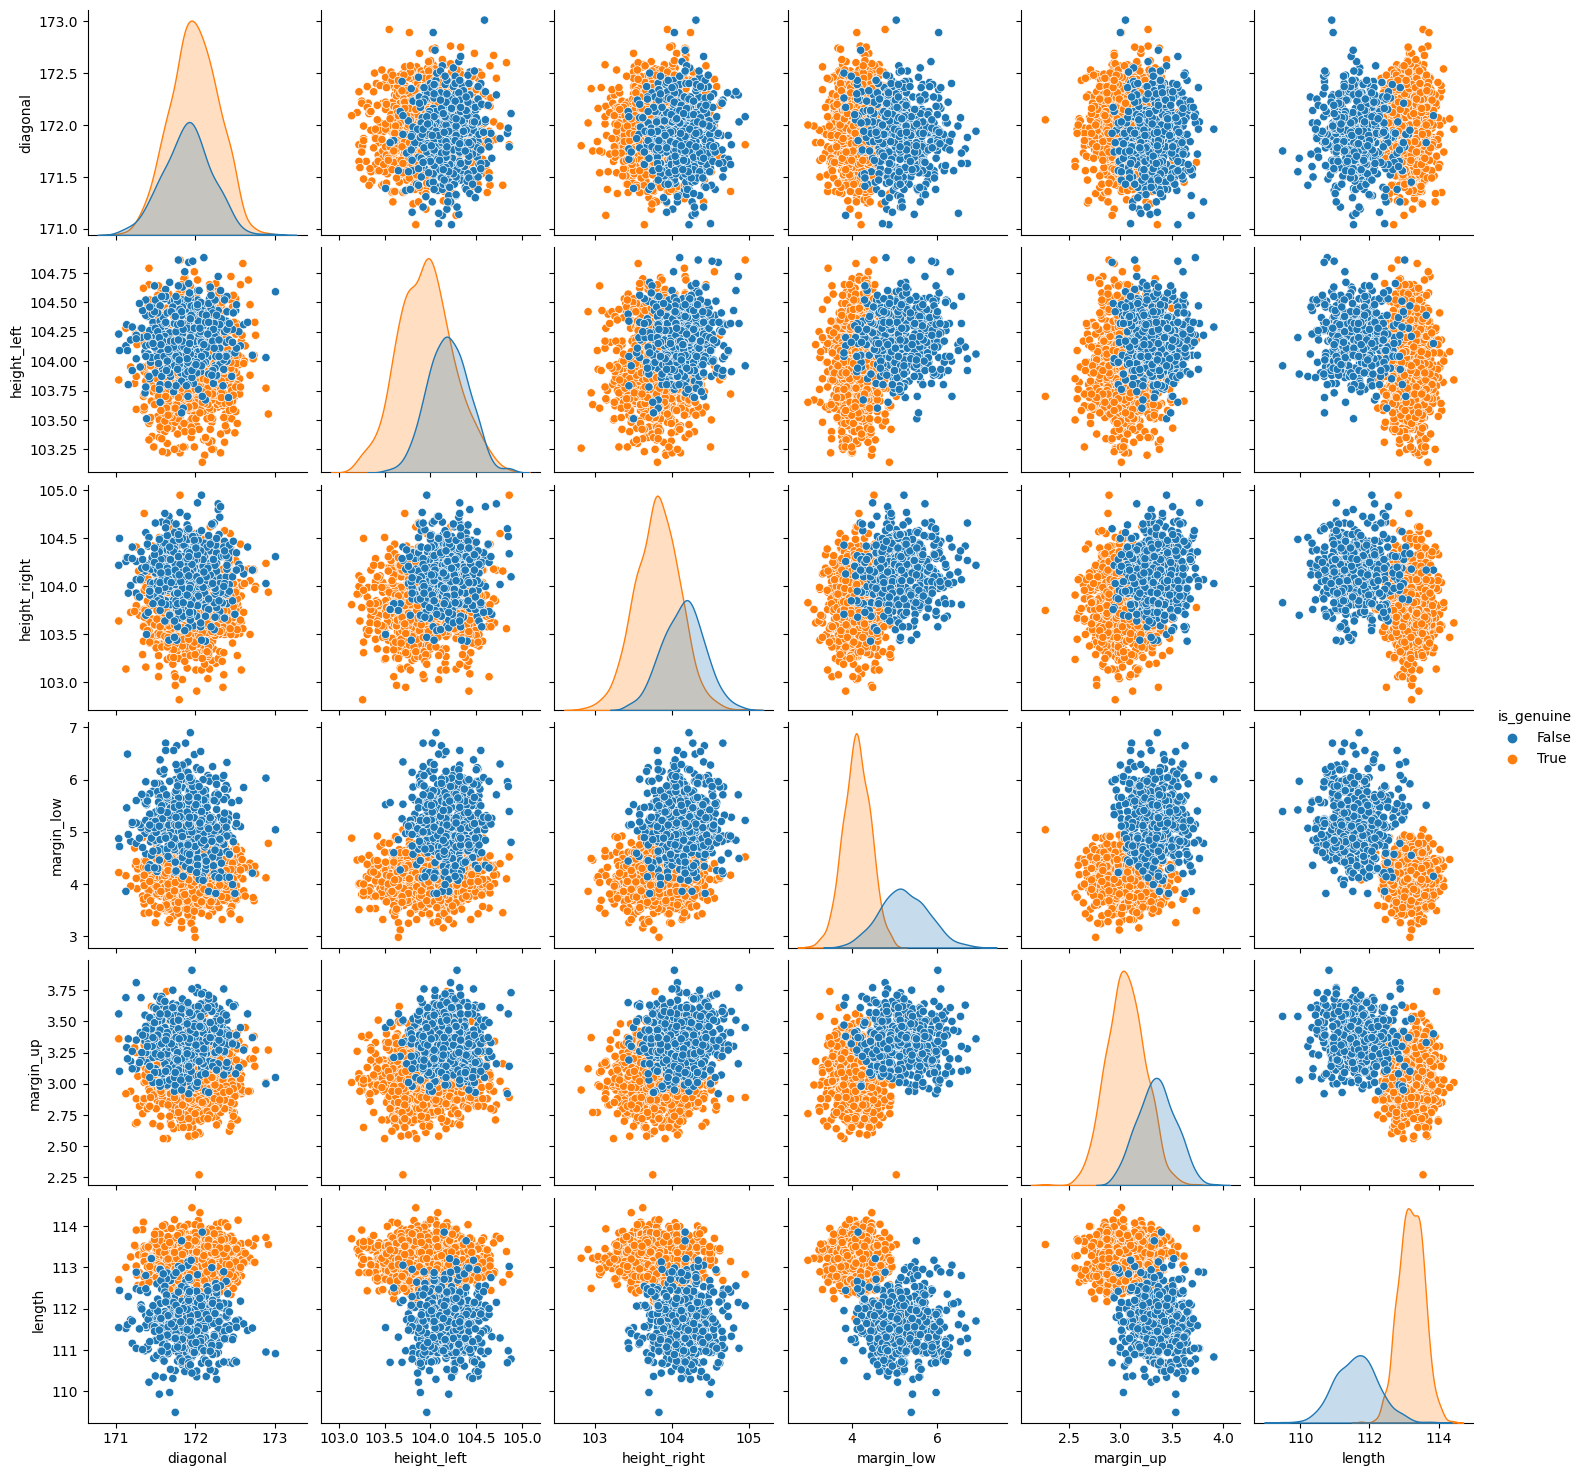

In [12]:
sns.pairplot(billets,hue='is_genuine')

In [13]:
billets.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


<Axes: >

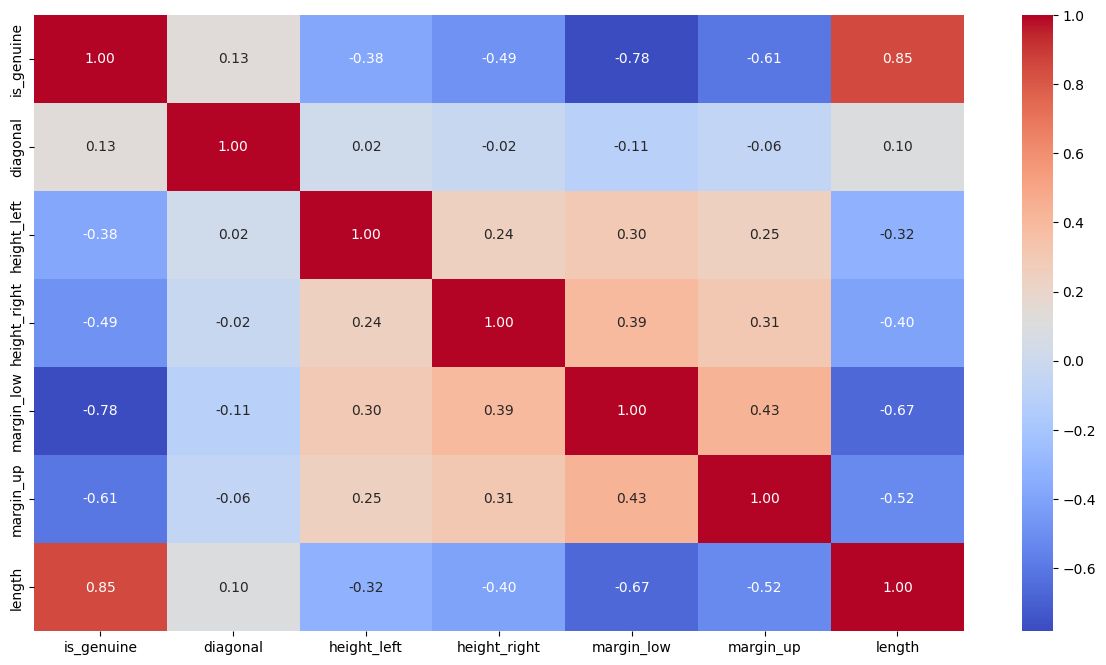

In [14]:
plt.figure(figsize=(15,8))
sns.heatmap(billets.corr(),annot=True,fmt=".2f",cmap="coolwarm")

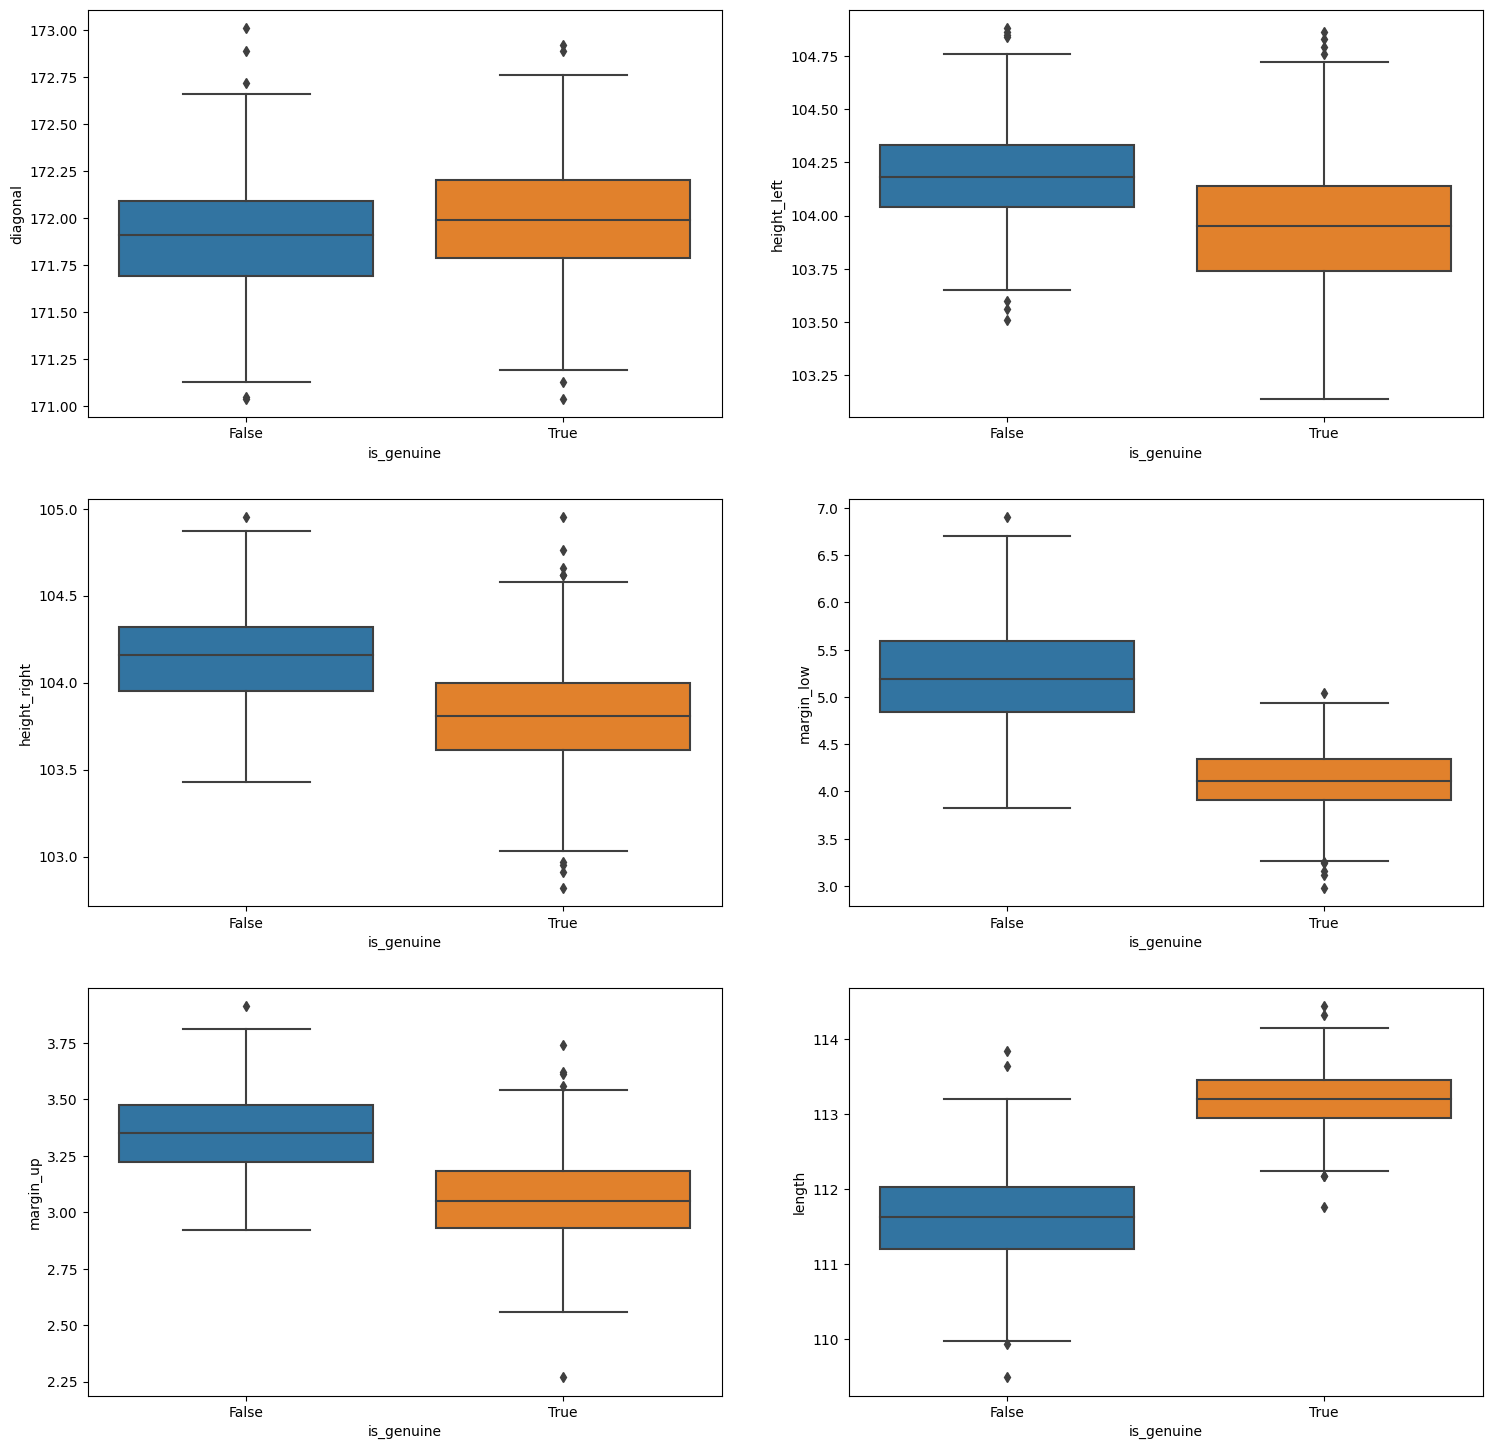

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(18,18))

for i in range(3):
    for j in range(2):
        sns.boxplot(ax=axes[i,j],
                    data=billets,
                    x='is_genuine',
                    y=billets.columns[1:][2*i+j])

On remarque que nos faux billets ont des marges et des hauteurs plus importantes que les vrais billets. Les vrais billets semblent aussi plus long que les faux

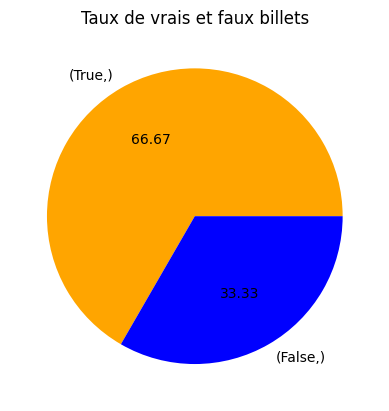

In [16]:
#Répartion des billets
billets[['is_genuine']].value_counts().plot.pie(autopct='%.2f',colors=['orange','blue'])
plt.title('Taux de vrais et faux billets')
plt.show()

# **Regression lineaire**
Remplacer les valeurs manquantes la colonne margin_low avec les valeurs obtenus par la regression lineaire

## **Trouver le modèle**

In [17]:
margin_low_sans_nan=billets.dropna()
display(margin_low_sans_nan)
margin_low_sans_nan.info()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


In [18]:
margin_low_nan=billets[billets.isnull().values.any(1)]
display(margin_low_nan)
margin_low_nan.info()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     bool   
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    0 non-null      float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: bool(1), float64(6)
memory usage: 2.1 KB


In [19]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=margin_low_sans_nan).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Tue, 14 Nov 2023   Prob (F-statistic):          2.60e-202
Time:                        11:27:33   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

On constate ici que tous les paramètres sont significatifs, car leur p-valeur sont inférieure à 5 % (P>|t|), le niveau de test que nous souhaitons. On peut donc utiliser ce modèle à des fins de prévision.

Le  R2  vaut environ 0.477, et le  R2  ajusté est d'environ 0.476 ce qui signifie que notre modèle explique environ 47.7% de la variance dans la variable dépendante. C'est une mesure de l'adéquation du modèle aux données. Plus le R-squared est proche de 1, mieux le modèle explique les variations des données.




## **Tester le modèle**

Nous allons ici réaliser les tests à un niveau  α=5 % :

In [20]:
alpha = 0.05

Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [21]:
n = margin_low_sans_nan.shape[0]
p = 6
print(n, p)

1463 6


Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé analyses.

In [22]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

### **Calculez les leviers**

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de  2∗pn .

In [23]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n
print(seuil_levier)

0.008202323991797676


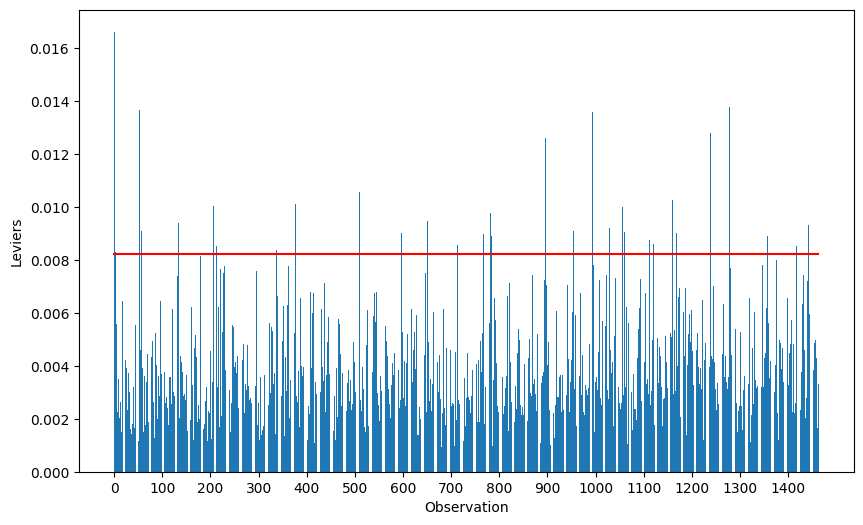

In [24]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, n, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
plt.show()


Pour sélectionner les points pour lesquels le levier est supérieur au seuil, on exécute la ligne suivante :

In [25]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
0,1,0.016606
2,3,0.008298
34,35,0.009156
52,53,0.013635
56,57,0.009087
...,...,...
1416,1417,0.008521
1417,1418,0.008870
1428,1429,0.008390
1441,1442,0.009325


### **Calculez les résidus studentisés**
Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [26]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
print(seuil_rstudent)

1.9615946239395787


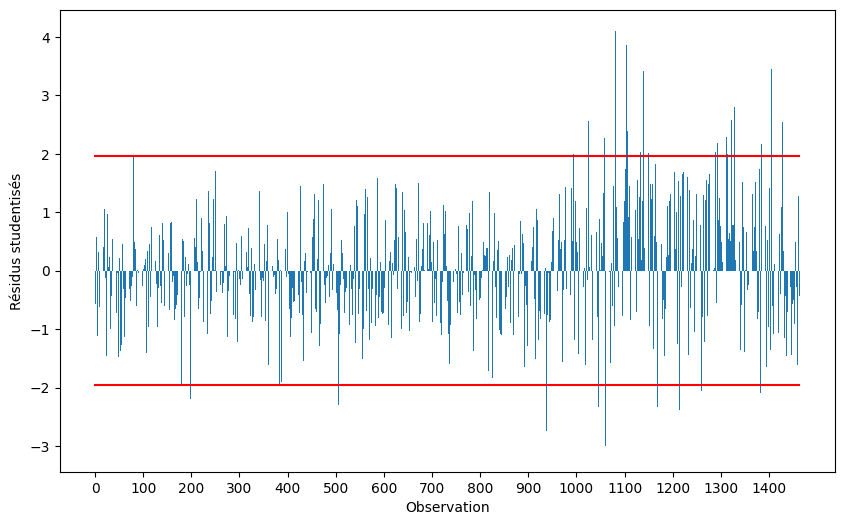

In [27]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, n, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

### **Déterminez la distance de Cook**

Pour trouver la distance de Cook, nous exécutons ceci :

In [28]:
influence = reg_multi.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p.

In [29]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)
print(seuil_dcook)

0.002745367192862045


On peut détecter les observations influentes comme ceci :

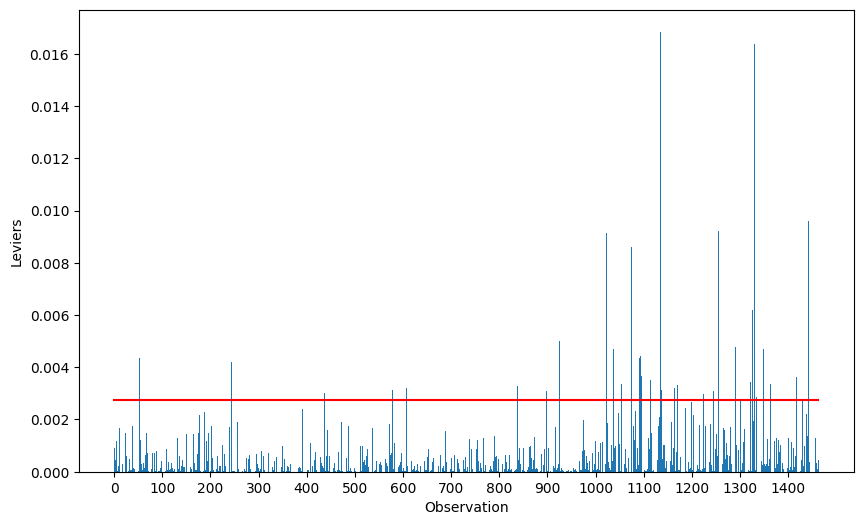

In [30]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, n, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
plt.show()

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.


### **Vérifier la colinéarité des variables**

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [31]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.013612899068628,
 1.1382605736082476,
 1.2301145155560345,
 1.4044037781843621,
 1.5769501453665853]

La multicolinéarité se produit lorsqu’il existe deux ou plusieurs variables indépendantes dans un modèle de régression multiple, qui ont une forte corrélation entre elles. Lorsque certaines caractéristiques sont fortement corrélées, nous pouvons avoir des difficultés à distinguer leurs effets individuels sur la variable dépendante. La multicolinéarité peut être détectée à l’aide de diverses techniques, l’une de ces techniques étant le facteur d’inflation de la variance ( VIF ).

VIF commence à 1 et n'a pas de limite supérieure

VIF = 1, pas de corrélation entre la variable indépendante et les autres variables

VIF supérieur à 5 ou 10 indique une forte multicolinéarité entre cette variable indépendante et les autres

Ici, tous les coefficients sont inférieurs à 5, il n'y a donc pas de problème de colinéarité.

### **Testez l’homoscédasticité**

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [32]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.7595352162878e-16


La p-valeur ici est  très proche de zéro (7.7595352162878e-16)et inférieure à  5 %, on  rejette  l'hypothèse  H0  selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité) ce qui signifie que l'homoscédasticité n'est pas satisfaite.

### **Testez la normalité des résidus**

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [33]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9857882857322693, pvalue=8.540482210328548e-11)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0.00000000008 < 0.05). Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.


# **Appliquer le modèle sur le jeux de données**

In [34]:
margin_low_prev= reg_multi.predict(margin_low_nan)
print(margin_low_prev)

72      4.318525
99      4.393668
151     4.410457
197     4.319014
241     4.650617
251     3.803308
284     4.179736
334     4.127442
410     4.135034
413     4.160539
445     4.177420
481     3.768554
505     4.058764
611     4.298047
654     4.160607
675     4.094065
710     4.439846
739     4.470650
742     4.341643
780     4.080414
798     3.614306
844     4.371811
845     4.093621
871     4.249629
895     3.893748
919     3.746333
945     4.237415
946     4.710533
981     4.137780
1076    5.050277
1121    4.802145
1176    5.067584
1303    5.047570
1315    4.778967
1347    5.726993
1435    5.185862
1438    5.140043
dtype: float64


In [35]:
display(margin_low_nan)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


In [36]:
#display(margin_low_nan['margin_low'])
margin_low_nan['margin_low']=margin_low_prev
display(margin_low_nan)

<ipython-input-36-89aa6ec81691>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margin_low_nan['margin_low']=margin_low_prev


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.318525,3.25,112.79
99,True,171.93,104.07,104.18,4.393668,3.14,113.08
151,True,172.07,103.80,104.38,4.410457,3.02,112.93
197,True,171.45,103.66,103.80,4.319014,3.62,113.27
241,True,171.83,104.14,104.06,4.650617,3.02,112.36
251,True,171.80,103.26,102.82,3.803308,2.95,113.22
284,True,171.92,103.83,103.76,4.179736,3.23,113.29
334,True,171.85,103.70,103.96,4.127442,3.00,113.36
410,True,172.56,103.72,103.51,4.135034,3.12,112.95
413,True,172.30,103.66,103.50,4.160539,3.16,112.95


In [37]:
billets=pd.concat([margin_low_sans_nan, margin_low_nan])
display(billets)
billets.info()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.047570,2.93,111.21
1315,False,172.08,104.15,104.17,4.778967,3.40,112.29
1347,False,171.72,104.46,104.12,5.726993,3.61,110.31
1435,False,172.66,104.33,104.41,5.185862,3.56,111.47


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


# **Régression logistique**

In [38]:
#Diviser le jeu de données en 2 parties: 80% pour le jeu d'entrainement et 20% pour le jeu de test
train, test = train_test_split(billets, test_size=0.2, random_state=42)

In [39]:
train

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
390,True,171.66,103.65,103.44,3.260000,2.99,112.89
551,True,171.56,103.44,104.09,4.410000,2.97,113.59
1121,False,171.40,104.38,104.19,4.802145,3.17,112.39
1143,False,171.90,104.25,104.64,4.460000,3.07,110.86
331,True,172.40,104.17,104.09,4.460000,3.02,113.16
...,...,...,...,...,...,...,...
1161,False,171.92,104.29,104.27,5.760000,3.13,111.37
1328,False,172.10,104.22,103.99,5.260000,3.24,111.94
884,True,172.57,103.78,103.65,4.270000,3.04,113.00
1496,False,172.19,104.63,104.44,5.270000,3.37,110.97


In [40]:
train.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,171.962925,104.029933,103.918925,4.467894,3.147692,112.694483
std,0.307148,0.301009,0.328429,0.655438,0.231385,0.872659
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.930000
25%,171.767500,103.810000,103.710000,4.010000,2.980000,112.070000
50%,171.960000,104.040000,103.910000,4.300000,3.130000,112.980000
75%,172.170000,104.230000,104.152500,4.820000,3.310000,113.350000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.440000


In [41]:
test

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1147,False,172.43,104.06,104.02,4.93,3.33,111.59
1403,False,171.53,104.25,104.17,4.30,3.50,112.23
432,True,171.47,104.46,104.30,4.12,3.06,113.59
423,True,171.70,104.32,104.07,4.21,2.67,112.73
462,True,171.48,103.95,103.93,4.52,2.91,113.21
...,...,...,...,...,...,...,...
1012,False,171.37,103.73,104.18,4.97,3.34,110.98
820,True,171.88,104.44,103.50,4.53,3.06,113.52
1297,False,171.96,104.47,104.06,4.84,3.76,111.04
1182,False,172.05,104.15,104.56,5.35,3.56,111.20


In [42]:
test.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,300.00000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,171.94050,104.027933,103.925833,4.545799,3.166600,112.614567
std,0.29708,0.293681,0.314642,0.673657,0.233294,0.871534
min,171.04000,103.200000,103.030000,3.260000,2.610000,109.490000
25%,171.72750,103.840000,103.700000,4.067500,2.990000,111.900000
50%,171.94000,104.010000,103.930000,4.380000,3.170000,112.935000
75%,172.15000,104.230000,104.140000,4.975000,3.330000,113.282500
max,172.74000,104.830000,104.950000,6.700000,3.760000,114.130000


In [43]:
#modèle de régression logistique
reg_log = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length', data=train, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1193
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -33.111
Date:                                       Tue, 14 Nov 2023   Deviance:                       66.222
Time:                                               11:27:46   Pearson chi2:                 1.72e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7002
Covariance Type:                                   nonrobust                      

Certaines des variables obtenues ont des p-valeurs qui sont inférieures au niveau de test de 5 %, (P>|z|) ce qui nous indique qu'elles sont bien significatives. Certaines autres ne sont pas en dessous de ce seuil.

On peut donc passer sur une procédure de sélection en retirant les variables non significatives au fur et à mesure.

Là il s'agit des variables "diagonal" et "height_left"
On commence par "diagonal" avec p-valeur=0.8

In [44]:
#Régression logistique sans variable "diagonal"
reg_log = smf.glm('is_genuine~height_left+height_right+margin_low+margin_up+length', data=train, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1194
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -33.143
Date:                                       Tue, 14 Nov 2023   Deviance:                       66.286
Time:                                               11:27:46   Pearson chi2:                 1.73e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7002
Covariance Type:                                   nonrobust                      

In [45]:
#Régression logistique sans variable "height_left"
reg_log = smf.glm('is_genuine~height_right+margin_low+margin_up+length', data=train, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1195
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -33.292
Date:                                       Tue, 14 Nov 2023   Deviance:                       66.584
Time:                                               11:27:46   Pearson chi2:                 1.92e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7001
Covariance Type:                                   nonrobust                      

Certaines des variables obtenues ont des p-valeurs qui sont inférieures au niveau de test de 5 %, (P>|z|) ce qui nous indique qu'elles sont bien significatives.On peut donc utiliser ce modèle pour des prévisions.

In [46]:
#On fait le test du modèle
billets_log= round(reg_log.predict(test))
print(billets_log)

1147    1.0
1403    1.0
432     0.0
423     0.0
462     0.0
       ... 
1012    1.0
820     0.0
1297    1.0
1182    1.0
847     0.0
Length: 300, dtype: float64


In [47]:
test

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1147,False,172.43,104.06,104.02,4.93,3.33,111.59
1403,False,171.53,104.25,104.17,4.30,3.50,112.23
432,True,171.47,104.46,104.30,4.12,3.06,113.59
423,True,171.70,104.32,104.07,4.21,2.67,112.73
462,True,171.48,103.95,103.93,4.52,2.91,113.21
...,...,...,...,...,...,...,...
1012,False,171.37,103.73,104.18,4.97,3.34,110.98
820,True,171.88,104.44,103.50,4.53,3.06,113.52
1297,False,171.96,104.47,104.06,4.84,3.76,111.04
1182,False,172.05,104.15,104.56,5.35,3.56,111.20


In [48]:
#false
a_prevoir = pd.DataFrame({'height_right':104.02,'margin_low':4.93, 'margin_up': 3.33, 'length' : 111.59}, index=[0])
billet_prev = reg_log.predict(a_prevoir)
print(round(billet_prev[0], 2))

1.0


In [49]:
#true
a_prevoir = pd.DataFrame({'height_right':103.83	,'margin_low':3.79, 'margin_up': 3.14, 'length' : 113.85}, index=[0])
billet_prev = reg_log.predict(a_prevoir)
print(round(billet_prev[0], 2))

0.0


In [50]:
test_log=test.copy()
test_log['reg_log_previsions']=billets_log
test_log


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,reg_log_previsions
1147,False,172.43,104.06,104.02,4.93,3.33,111.59,1.0
1403,False,171.53,104.25,104.17,4.30,3.50,112.23,1.0
432,True,171.47,104.46,104.30,4.12,3.06,113.59,0.0
423,True,171.70,104.32,104.07,4.21,2.67,112.73,0.0
462,True,171.48,103.95,103.93,4.52,2.91,113.21,0.0
...,...,...,...,...,...,...,...,...
1012,False,171.37,103.73,104.18,4.97,3.34,110.98,1.0
820,True,171.88,104.44,103.50,4.53,3.06,113.52,0.0
1297,False,171.96,104.47,104.06,4.84,3.76,111.04,1.0
1182,False,172.05,104.15,104.56,5.35,3.56,111.20,1.0


In [51]:
test

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1147,False,172.43,104.06,104.02,4.93,3.33,111.59
1403,False,171.53,104.25,104.17,4.30,3.50,112.23
432,True,171.47,104.46,104.30,4.12,3.06,113.59
423,True,171.70,104.32,104.07,4.21,2.67,112.73
462,True,171.48,103.95,103.93,4.52,2.91,113.21
...,...,...,...,...,...,...,...
1012,False,171.37,103.73,104.18,4.97,3.34,110.98
820,True,171.88,104.44,103.50,4.53,3.06,113.52
1297,False,171.96,104.47,104.06,4.84,3.76,111.04
1182,False,172.05,104.15,104.56,5.35,3.56,111.20


In [52]:
test_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 1147 to 847
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_genuine          300 non-null    bool   
 1   diagonal            300 non-null    float64
 2   height_left         300 non-null    float64
 3   height_right        300 non-null    float64
 4   margin_low          300 non-null    float64
 5   margin_up           300 non-null    float64
 6   length              300 non-null    float64
 7   reg_log_previsions  300 non-null    float64
dtypes: bool(1), float64(7)
memory usage: 19.0 KB


In [53]:
pd.crosstab(test_log.is_genuine, test_log.reg_log_previsions.apply(lambda x: 'True' if x==0 else 'False'))

reg_log_previsions,False,True
is_genuine,,
False,110,1
True,2,187


# **k-means**

Au préalable, il est nécessaire de centrer-réduire les données. C’est à dire, recalculer chaque valeur de manière à ce que la moyenne de la variable soit égale à 0 et la variance et l’écart-type égale à 1. Pour une variable donnée, on soustrait à chaque valeur la moyenne de la variable, puis on divise le tout par l’écart-type.

In [54]:
#extraire des valeurs numériques de dataset
X = train.values
names = train.index
features = train.columns

In [55]:
#Centrage et Réduction
scaler = StandardScaler()

In [56]:
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[ 0.69257111, -0.98666168, -1.26272608, -1.45883651, -1.84364996,
        -0.68179713,  0.22414039],
       [ 0.69257111, -1.31237323, -1.96067083,  0.52110551, -0.08836628,
        -0.76826932,  1.02662067],
       [-1.44389505, -1.83351169,  1.16346282,  0.82571197,  0.51017817,
         0.09645251, -0.34905982],
       [-1.44389505, -0.20495399,  0.73140179,  2.19644106, -0.01204959,
        -0.3359084 , -2.10305244],
       [ 0.69257111,  1.42360372,  0.46551807,  0.52110551, -0.01204959,
        -0.55208886,  0.5336685 ]])

In [57]:
#Une liste vide pour enregistrer les inerties :
intertia_list = [ ]

# Notre liste de nombres de clusters :
k_list = range(1, 10)

# Pour chaque nombre de clusters :
for k in k_list :

    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)

    # On entraine
    kmeans.fit(X_scaled)

    # On enregistre l'inertie obtenue :
    intertia_list.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

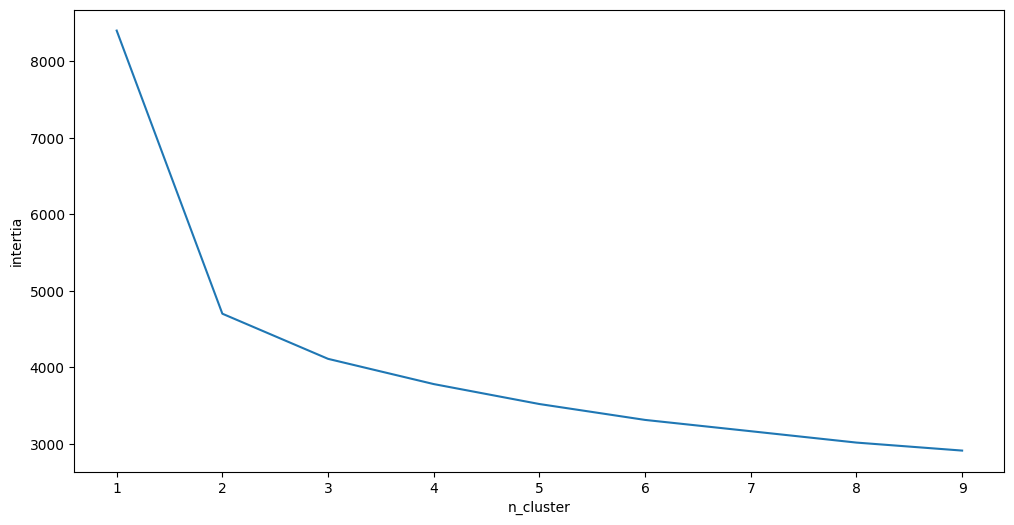

In [58]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(k_list, intertia_list)

Méthode de coude montre 2 clusters

In [59]:
a=2
kmeans = KMeans(n_clusters=a, random_state=60)
kmeans.fit(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=60)

In [60]:
kmeans.inertia_

4700.5465409411845

In [61]:
#Les numéros des clusters 0 ou 1
kmeans.labels_

array([1, 1, 0, ..., 1, 0, 0], dtype=int32)

In [62]:
labels= kmeans.labels_
train1=train.copy()
train1["clusters_kmeans"]=labels
train1

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,clusters_kmeans
390,True,171.66,103.65,103.44,3.260000,2.99,112.89,1
551,True,171.56,103.44,104.09,4.410000,2.97,113.59,1
1121,False,171.40,104.38,104.19,4.802145,3.17,112.39,0
1143,False,171.90,104.25,104.64,4.460000,3.07,110.86,0
331,True,172.40,104.17,104.09,4.460000,3.02,113.16,1
...,...,...,...,...,...,...,...,...
1161,False,171.92,104.29,104.27,5.760000,3.13,111.37,0
1328,False,172.10,104.22,103.99,5.260000,3.24,111.94,0
884,True,172.57,103.78,103.65,4.270000,3.04,113.00,1
1496,False,172.19,104.63,104.44,5.270000,3.37,110.97,0


Comparer des is_genuine avec cluster_kmeans

In [63]:
pd.crosstab(train1.is_genuine, train1.clusters_kmeans.apply(lambda x: 'True' if x==1 else 'False'))

clusters_kmeans,False,True
is_genuine,,
False,387,2
True,1,810


In [64]:
#Centroïdes
centroides_kmeans = train1.groupby('clusters_kmeans').mean()
display(centroides_kmeans)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
clusters_kmeans,,,,,,,
0,0.002577,171.899691,104.195335,104.154407,5.208220,3.346186,111.622474
1,0.997537,171.993140,103.950899,103.806404,4.114143,3.052845,113.206724


In [65]:
X1 = test.values
names1 = test.index
features1 = test.columns


In [66]:
test

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1147,False,172.43,104.06,104.02,4.93,3.33,111.59
1403,False,171.53,104.25,104.17,4.30,3.50,112.23
432,True,171.47,104.46,104.30,4.12,3.06,113.59
423,True,171.70,104.32,104.07,4.21,2.67,112.73
462,True,171.48,103.95,103.93,4.52,2.91,113.21
...,...,...,...,...,...,...,...
1012,False,171.37,103.73,104.18,4.97,3.34,110.98
820,True,171.88,104.44,103.50,4.53,3.06,113.52
1297,False,171.96,104.47,104.06,4.84,3.76,111.04
1182,False,172.05,104.15,104.56,5.35,3.56,111.20


In [67]:
#scaler.fit(X1)
X1_scaled = scaler.transform(X1)

In [68]:
kmeans.predict(X1_scaled)

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1], d

In [69]:
labels1= kmeans.predict(X1_scaled)
test1=test.copy()
test1["clusters_kmeans"]=labels1
test1

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,clusters_kmeans
1147,False,172.43,104.06,104.02,4.93,3.33,111.59,0
1403,False,171.53,104.25,104.17,4.30,3.50,112.23,0
432,True,171.47,104.46,104.30,4.12,3.06,113.59,1
423,True,171.70,104.32,104.07,4.21,2.67,112.73,1
462,True,171.48,103.95,103.93,4.52,2.91,113.21,1
...,...,...,...,...,...,...,...,...
1012,False,171.37,103.73,104.18,4.97,3.34,110.98,0
820,True,171.88,104.44,103.50,4.53,3.06,113.52,1
1297,False,171.96,104.47,104.06,4.84,3.76,111.04,0
1182,False,172.05,104.15,104.56,5.35,3.56,111.20,0


In [70]:
pd.crosstab(test1.is_genuine, test1.clusters_kmeans.apply(lambda x: 'True' if x==1 else 'False'))

clusters_kmeans,False,True
is_genuine,,
False,111,0
True,0,189


# **Régression logistique sans NaN**

In [71]:
display(margin_low_sans_nan)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [72]:
#Diviser le jeu de données en 2 parties: 80% pour le jeu d'entrainement et 20% pour le jeu de test
train2, test2 = train_test_split(margin_low_sans_nan, test_size=0.2, random_state=42)

In [73]:
train2

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
893,True,172.20,103.52,103.78,3.66,3.40,113.35
1071,False,171.50,103.90,103.98,4.82,3.40,112.07
260,True,172.27,103.71,103.64,4.64,2.67,113.63
1097,False,172.51,104.43,104.17,5.11,3.08,111.70
1224,False,171.74,104.52,104.23,5.59,3.61,112.14
...,...,...,...,...,...,...,...
1161,False,171.92,104.29,104.27,5.76,3.13,111.37
1328,False,172.10,104.22,103.99,5.26,3.24,111.94
884,True,172.57,103.78,103.65,4.27,3.04,113.00
1496,False,172.19,104.63,104.44,5.27,3.37,110.97


In [74]:
test2

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1208,False,171.96,104.38,103.82,5.19,3.32,111.68
178,True,171.79,104.57,104.04,4.26,3.15,113.46
281,True,171.99,103.90,104.21,4.18,3.07,113.01
561,True,172.25,103.71,103.97,3.93,3.00,113.38
891,True,172.16,103.63,103.59,4.25,3.38,113.58
...,...,...,...,...,...,...,...
1491,False,171.79,104.18,104.54,5.13,3.51,112.40
493,True,172.55,103.97,104.04,4.25,3.34,113.36
494,True,172.08,104.19,104.03,4.11,2.99,113.50
1080,False,172.23,103.83,104.29,5.61,3.47,111.72


In [75]:
reg_log2 = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length', data=train2, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1195
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -33.292
Date:                                       Tue, 14 Nov 2023   Deviance:                       66.584
Time:                                               11:27:54   Pearson chi2:                 1.92e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7001
Covariance Type:                                   nonrobust                      

In [76]:
#Régression logistique sans variable "diagonal"
reg_log2 = smf.glm('is_genuine~height_left+height_right+margin_low+margin_up+length', data=train2, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1195
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -33.292
Date:                                       Tue, 14 Nov 2023   Deviance:                       66.584
Time:                                               11:27:54   Pearson chi2:                 1.92e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7001
Covariance Type:                                   nonrobust                      

In [77]:
#Régression logistique sans variable "height_left"
reg_log2 = smf.glm('is_genuine~height_right+margin_low+margin_up+length', data=train2, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1195
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -33.292
Date:                                       Tue, 14 Nov 2023   Deviance:                       66.584
Time:                                               11:27:54   Pearson chi2:                 1.92e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7001
Covariance Type:                                   nonrobust                      

In [78]:
#On fait le test du modèle
billets_log2= round(reg_log2.predict(test))
print(billets_log2)

1147    1.0
1403    1.0
432     0.0
423     0.0
462     0.0
       ... 
1012    1.0
820     0.0
1297    1.0
1182    1.0
847     0.0
Length: 300, dtype: float64


In [79]:
test_log2=test.copy()
test_log2['reg_log_previsions']=billets_log2
test_log2

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,reg_log_previsions
1147,False,172.43,104.06,104.02,4.93,3.33,111.59,1.0
1403,False,171.53,104.25,104.17,4.30,3.50,112.23,1.0
432,True,171.47,104.46,104.30,4.12,3.06,113.59,0.0
423,True,171.70,104.32,104.07,4.21,2.67,112.73,0.0
462,True,171.48,103.95,103.93,4.52,2.91,113.21,0.0
...,...,...,...,...,...,...,...,...
1012,False,171.37,103.73,104.18,4.97,3.34,110.98,1.0
820,True,171.88,104.44,103.50,4.53,3.06,113.52,0.0
1297,False,171.96,104.47,104.06,4.84,3.76,111.04,1.0
1182,False,172.05,104.15,104.56,5.35,3.56,111.20,1.0


In [80]:
pd.crosstab(test_log2.is_genuine, test_log2.reg_log_previsions.apply(lambda x: 'True' if x==0 else 'False'))

reg_log_previsions,False,True
is_genuine,,
False,110,1
True,2,187


# **Algorithme final**


In [81]:
billets_finale= pd.read_csv(os.path.join(working_directory, 'billets_production.csv'), delimiter=',')
billets_finale['vrai/faux']=round(reg_log.predict(billets_finale))
billets_finale['vrai/faux']=billets_finale['vrai/faux'].apply(lambda x: 'vrai' if x==0 else 'faux')
billets_finale

,diagonal,height_left,height_right,margin_low,margin_up,length,id,vrai/faux
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,faux
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,faux
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,faux
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,vrai
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,vrai
